In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей

# метрики
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

# для игнорирования предупреждений
import warnings
warnings.filterwarnings("ignore")

# Загрузка датасета
df = pd.read_csv('Dataset-Sales_FINAL.csv',parse_dates=True)
df.index.freq = 'MS'
print(len(df))
print(df.head())

36
   Year  Month   Revenue  Advertising expenses
0  2019      1  81764897               4088244
1  2019      2  85456774               5127406
2  2019      3  91753351               6422734
3  2019      4  99180273               7138520
4  2019      5  95725994               7978079


       Анализируемый датасет содержит данные дистрибьютора о продажах оборудования для ресторанов с 2019 по 2021 год. В нем хранятся данные о выручке и затратах на рекламную деятельность. 

In [2]:
# Создаем DatetimeIndex
df['date']=pd.to_datetime(dict(year=df['Year'], month=df['Month'], day=1))
df.head()

,Year,Month,Revenue,Advertising expenses,date
0,2019,1,81764897,4088244,2019-01-01
1,2019,2,85456774,5127406,2019-02-01
2,2019,3,91753351,6422734,2019-03-01
3,2019,4,99180273,7138520,2019-04-01
4,2019,5,95725994,7978079,2019-05-01


In [3]:
df.set_index('date', inplace=True)
df.index.freq = 'MS'
df.head()

,Year,Month,Revenue,Advertising expenses
date,,,,
2019-01-01,2019,1,81764897,4088244
2019-02-01,2019,2,85456774,5127406
2019-03-01,2019,3,91753351,6422734
2019-04-01,2019,4,99180273,7138520
2019-05-01,2019,5,95725994,7978079


In [4]:
# Удаляем ненужные столбцы
df = df.drop(['Month', 'Year'], axis = 1)
df

,Revenue,Advertising expenses
date,,
2019-01-01,81764897,4088244
2019-02-01,85456774,5127406
2019-03-01,91753351,6422734
2019-04-01,99180273,7138520
2019-05-01,95725994,7978079
2019-06-01,95334113,9120070
2019-07-01,96608040,10976020
2019-08-01,97470010,11696401
2019-09-01,92428131,9242813


In [5]:
# Описание основных статистик датасета
df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,Revenue,Advertising expenses
count,36.00,36.00
mean,97644378.83,8606501.31
std,21694202.09,4447140.47
min,39202486.00,0.00
25%,91826428.75,6098902.00
50%,98838176.00,9102223.50
75%,105373960.75,11028668.75
max,144277673.00,18756097.00


        Как видно из значений, приведенных выше, данные содержат выбросы, так как минимальное значение выручки 39 202 486 при нижнем квартиле 91 826 428,75.

<bound method _AxesBase.autoscale of <AxesSubplot:>>

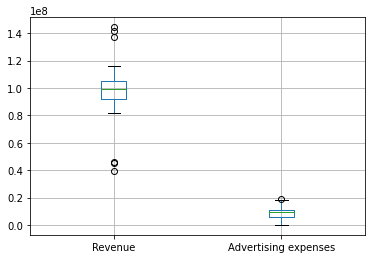

In [6]:
#Построим боксплот, гистограмму и график плотности.
df.boxplot(column=['Revenue', 'Advertising expenses']).autoscale

<AxesSubplot:xlabel='Revenue', ylabel='Density'>

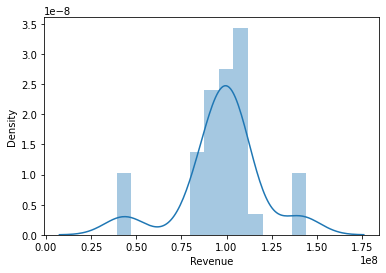

In [7]:
import seaborn as sns
sns.distplot(df['Revenue'].dropna())

        Полученные данные свидетельствуют о ненормальном распределении. Распространение ограничений на предприятия питания и торговли, связанных с COVID-19, отразилось на дистрибьюторах ресторанного оборудования. Период с апреля по июнь 2020 года охарактеризовался минимальной выручкой и отсутствием затрат на рекламу.

In [8]:
# Воспользуемся методом IQR.
IQR = df['Revenue'].quantile(0.75) - df['Revenue'].quantile(0.25)
lower_bound = df['Revenue'].quantile(0.25)-3*IQR
upper_bound = df['Revenue'].quantile(0.75)+3*IQR
print('lower_bound =', lower_bound)
print('upper_bound =', upper_bound)

lower_bound = 51183832.75
upper_bound = 146016556.75


In [10]:
# Для дальнейшего исследования заменим выбросы на среднее значение по столбцам.
mean = df['Revenue'].mean()
mean2 = df['Advertising expenses'].mean()
df.loc[((df.Revenue < lower_bound) | (df.Revenue > upper_bound)), 'Revenue'] = mean
df.loc[(df['Advertising expenses'] == 0), 'Advertising expenses'] = mean2
df.apply(lambda s: s.apply('{0:.2f}'.format))

,Revenue,Advertising expenses
date,,
2019-01-01,81764897.00,4088244.00
2019-02-01,85456774.00,5127406.00
2019-03-01,91753351.00,6422734.00
2019-04-01,99180273.00,7138520.00
2019-05-01,95725994.00,7978079.00
2019-06-01,95334113.00,9120070.00
2019-07-01,96608040.00,10976020.00
2019-08-01,97470010.00,11696401.00
2019-09-01,92428131.00,9242813.00


<AxesSubplot:xlabel='Advertising expenses', ylabel='Revenue'>

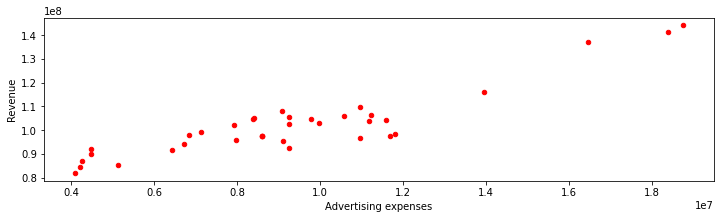

In [11]:
# Для оценки влияния рекламных затрат на выручку построим график разброса и матрицу корреляции.
df.plot.scatter (x = 'Advertising expenses', y = 'Revenue', figsize=(12,3), c = 'red')

<AxesSubplot:xlabel='date'>

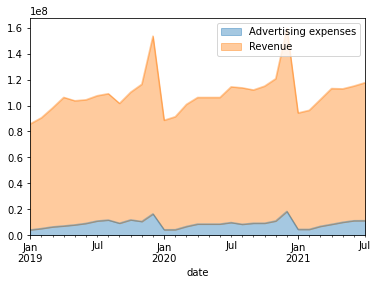

In [12]:
df[0:31].plot.area(y = ['Advertising expenses', 'Revenue'], alpha = 0.4, stacked=True)

                      Advertising expenses   Revenue
Advertising expenses              1.000000  0.910167
Revenue                           0.910167  1.000000


<AxesSubplot:>

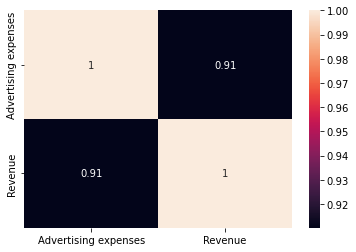

In [13]:
corr_matrix = df.loc[:,['Advertising expenses', 'Revenue']].corr()
print(corr_matrix)

# Используем тепловую карту для визуализации матрицы корреляции
sns.heatmap(corr_matrix, annot=True)

        Высокий коэффициент корреляции свидетельствуют о зависимости между этими переменными. Увеличение затрат на рекламу влечет за собой увеличение выручки. 

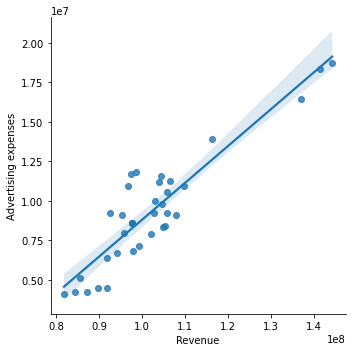

In [14]:
sns.lmplot(x='Revenue', y='Advertising expenses', data=df);

        Из приведенного выше графика мы можем видеть, что существует положительная линейная зависимость между затратами на рекламу и выручкой компании. 

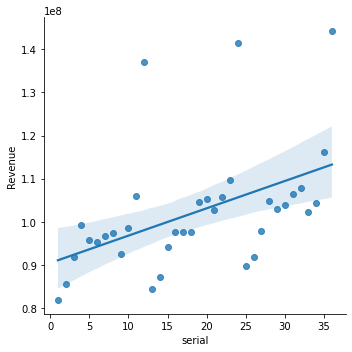

In [17]:
# Построим график линейной регресии для оценки зависимости выручки от даты, а также матрицу корреляции.
df.insert(0, 'serial', range(1, 1 + len(df)))
df.apply(lambda s: s.apply('{0:.2f}'.format))
sns.lmplot(x='serial', y='Revenue', data=df);

In [18]:
corr_matrix = df.loc[:,['Advertising expenses', 'Revenue', 'serial']].corr()
print(corr_matrix)

                      Advertising expenses   Revenue    serial
Advertising expenses              1.000000  0.910167  0.350648
Revenue                           0.910167  1.000000  0.476032
serial                            0.350648  0.476032  1.000000


        Проведенное исследование демонстрирует, что связь между датой и переменными выручки и рекламных затрат весьма расплывчатая.

<AxesSubplot:title={'center':'Dynamics of sales'}, xlabel='date', ylabel='Revenue'>

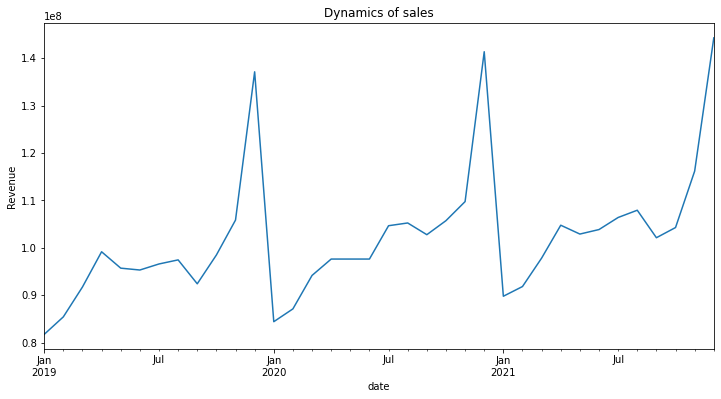

In [19]:
# Построим график временного ряда атрибута Revenue
df['Revenue'].plot(figsize=(12,6), title='Dynamics of sales', xlabel='date', ylabel='Revenue')

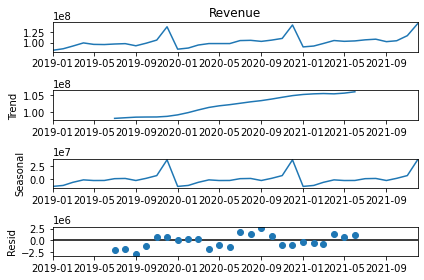

In [20]:
# Построим декомпозицию временного ряда.
result = seasonal_decompose(df['Revenue'], model='add').plot()

        На графике явно прослеживается сезонность и тренд увеличения выручки с течением времени.

        Чтобы проверить, является ли ряд стационарным, проведем тест Дики-Фуллера, а также запустим autoarima для автоатического подбора автоподбор оптимальных параметров для прогнозирования временного ряда.

In [21]:
from statsmodels.tsa.stattools import adfuller 
from numpy import log 
df = pd.read_csv('Dataset-Sales_FINAL.csv', names = ['value'], header = 0)
res = adfuller(df.value.dropna()) 
print('Augmented Dickey-Fuller Statistic: %f' % res[0]) 
print('p-value: %f' % res[1])

Augmented Dickey-Fuller Statistic: -3.000227
p-value: 0.034873


In [100]:
df

,serial,Revenue,Advertising expenses
date,,,
2019-01-01,1,8.176490e+07,4.088244e+06
2019-02-01,2,8.545677e+07,5.127406e+06
2019-03-01,3,9.175335e+07,6.422734e+06
2019-04-01,4,9.918027e+07,7.138520e+06
2019-05-01,5,9.572599e+07,7.978079e+06
2019-06-01,6,9.533411e+07,9.120070e+06
2019-07-01,7,9.660804e+07,1.097602e+07
2019-08-01,8,9.747001e+07,1.169640e+07
2019-09-01,9,9.242813e+07,9.242813e+06


In [101]:
# p-значение теста ADF меньше уровня значимости (0,05). Тест показал, что временной ряд является стационарным.
auto_arima(df['Revenue']).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -630.071
Date:                Sat, 26 Mar 2022   AIC                           1262.143
Time:                        16:02:06   BIC                           1263.698
Sample:                             0   HQIC                          1262.680
                                 - 36                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.463e+14   3.12e+13      7.897      0.000    1.85e+14    3.07e+14
===================================================================================
Ljung-Box (L1) (Q):                   3.71   Jarque-Bera (JB):                64.32
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.93   Skew:                            -1.75
Prob(H) (two-sided):                  0.91   Kurtosis:                         8.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
#Разделим данные на train/test и установим один (последний) год для тестироваия.
train = df.iloc[:len(df)-12]
test = df.iloc[len(df)-12:]

In [104]:
# Обучим модель ARIMA(0,1,0) на train['Revenue']
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train['Revenue'], order=(0,1,0))
results = model.fit(disp=False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                   23
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -412.248
Method:                           css   S.D. of innovations       14722756.873
Date:                Sat, 26 Mar 2022   AIC                            828.497
Time:                        16:03:51   BIC                            830.768
Sample:                    02-01-2019   HQIC                           829.068
                         - 12-01-2020                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.591e+06   3.07e+06      0.844      0.399   -3.43e+06    8.61e+06
==============================================================================
"""

In [105]:
#получим прогнозируемые значения
start = len(train)
end = len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename(' Predictions ARIMA(0, 1, 0)')
predictions

2021-01-01    1.439468e+08
2021-02-01    1.465377e+08
2021-03-01    1.491286e+08
2021-04-01    1.517195e+08
2021-05-01    1.543104e+08
2021-06-01    1.569014e+08
2021-07-01    1.594923e+08
2021-08-01    1.620832e+08
2021-09-01    1.646741e+08
2021-10-01    1.672650e+08
2021-11-01    1.698559e+08
2021-12-01    1.724468e+08
Freq: MS, Name:  Predictions ARIMA(0, 1, 0), dtype: float64

In [106]:
#Сравниваем результаты
for i in range (len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['Revenue'][i]}")

predicted=143946790.2, expected=89805489.0
predicted=146537702.4, expected=91850788.0
predicted=149128614.7, expected=97844794.0
predicted=151719526.9, expected=104778133.0
predicted=154310439.1, expected=102914875.0
predicted=156901351.3, expected=103866156.0
predicted=159492263.5, expected=106409746.0
predicted=162083175.7, expected=107937525.0
predicted=164674088.0, expected=102142658.0
predicted=167265000.2, expected=104290946.0
predicted=169855912.4, expected=116192222.0
predicted=172446824.6, expected=144277673.0


[Text(0.5, 0, 'date'), Text(0, 0.5, 'Revenue')]

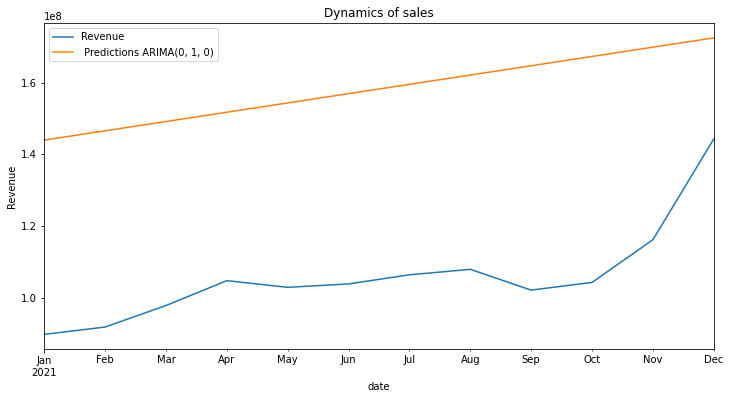

In [107]:
# Построим график прогнозируемых и известных значений
ax = test['Revenue'].plot(legend=True, figsize=(12,6), title = 'Dynamics of sales')
predictions.plot(legend=True)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel='date', ylabel='Revenue')

In [108]:
# Оценим качество модели с помощью MSE и RMSE
error=mean_squared_error(test['Revenue'], predictions)
print(f'ARIMA(0, 1, 0)MSE Error: {error:11.10}')

ARIMA(0, 1, 0)MSE Error: 2.792367411e+15


In [109]:
error=rmse(test['Revenue'], predictions)
print(f'ARIMA(0, 1,0)RMSE Error: {error:11.10}')

ARIMA(0, 1,0)RMSE Error: 52842855.82


In [112]:
#Натренируем модель на полном датасете и предскажем на год вперед
model = ARIMA(df['Revenue'], order=(0,1,0))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.79955D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.800D+01
  F =   17.995502112479592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:              D.Revenue   No. Observations:                   35
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -629.843
Method:                           css   S.D. of innovations       15816489.283
Date:                Sat, 26 Mar 2022   AIC                           1263.685
Time:                        16:06:57   BIC                           1266.796
Sample:                    02-01-2019   HQIC                          1264.759
                         - 12-01-2021                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.786e+06   2.67e+06      0.668      0.504   -3.45e+06    7.03e+06
==============================================================================
"""

In [113]:
fcast = results.predict(len(df),len(df)+12, typ='levels').rename('ARIMA(0, 1, 0)Forecast')
fcast

2022-01-01    1.460638e+08
2022-02-01    1.478498e+08
2022-03-01    1.496359e+08
2022-04-01    1.514220e+08
2022-05-01    1.532081e+08
2022-06-01    1.549941e+08
2022-07-01    1.567802e+08
2022-08-01    1.585663e+08
2022-09-01    1.603524e+08
2022-10-01    1.621385e+08
2022-11-01    1.639245e+08
2022-12-01    1.657106e+08
2023-01-01    1.674967e+08
Freq: MS, Name: ARIMA(0, 1, 0)Forecast, dtype: float64

<AxesSubplot:>

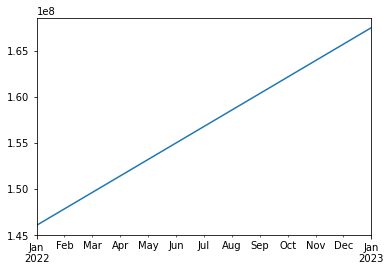

In [114]:
# Построим график предсказаний и график исходных данных
fcast.plot()

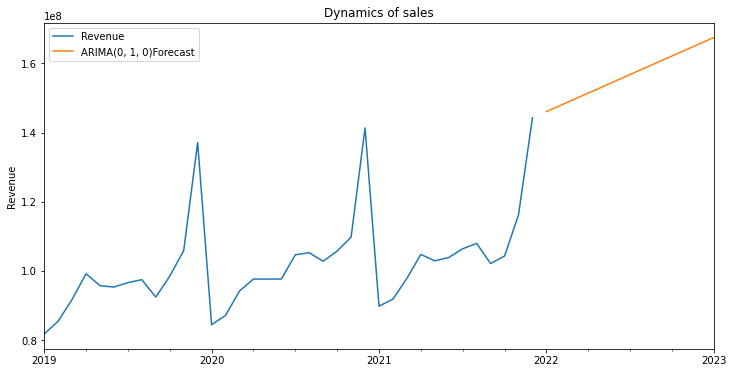

In [115]:
# Отобразим общий график
l=df['Revenue'].plot(figsize=(12,6), legend=True, title='Dynamics of sales', xlabel='', ylabel='Revenue')
fcast.plot(legend=True)
l.autoscale(axis='x', tight=True)

        Полученные значения MSE и RMSE говорят о нам высокой ошибке и неточности прогноза. Причиной может быть неверно подобранная модель или недостаточность данных для прогноза.
        Построим графики автокорреляции и частичной автокорреляции и подберем параметры для построения модели с учетом коэффициента сезонности.

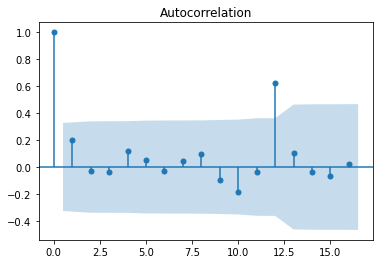

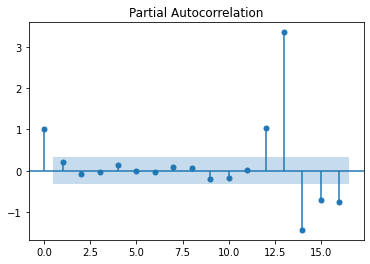

In [116]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
plot_acf(df['Revenue'])
plt.show()
plot_pacf(df['Revenue'])
plt.show()

      Из графика PACF видно, что порядок AR будет p=14 (максимальный номер коэффициента сильно отличный от 0), а по ACF видно, что q=2 (количество автокорреляционных коэффициентов сильно отличных от 0).

In [117]:
auto_arima(df['Revenue'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:                        y   No. Observations:                   36
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -391.836
Date:                  Sat, 26 Mar 2022   AIC                            787.671
Time:                          16:27:53   BIC                            790.028
Sample:                               0   HQIC                           788.296
                                   - 36                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.963e+06   6.09e+05      6.512      0.000    2.77e+06    5.16e+06
sigma2      8.882e+12   2.95e+12      3.014      0.003    3.11e+12    1.47e+13
===================================================================================
Ljung-Box (L1) (Q):                   6.39   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.01   Prob(JB):                         0.89
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [118]:
#Разделим данные на train/test и установим один (последний) год для тестироваия.
train1 = df.iloc[:len(df)-12]
test1 = df.iloc[len(df)-12:]

In [119]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [151]:
# Обучим модель SARIMA(14,1,2)(0,1,0,12) на train['Revenue']
model = SARIMAX(train1['Revenue'], order=(14,1,2), seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.46829D+00    |proj g|=  4.58102D+00

At iterate    5    f=  7.19695D+00    |proj g|=  9.45963D-02

At iterate   10    f=  7.19679D+00    |proj g|=  6.62791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     11     13      1     0     0   8.821D-04   7.197D+00
  F =   7.1967884034969272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Revenue   No. Observations:                   24
Model:             SARIMAX(14, 1, 2)x(0, 1, [], 12)   Log Likelihood                -172.723
Date:                              Sat, 26 Mar 2022   AIC                            379.446
Time:                                      17:47:55   BIC                            386.210
Sample:                                  01-01-2019   HQIC                           375.182
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0022     71.051    3.1e-05      1.000    -139.256     139.260
ar.L2         -0.0011    128.085   -8.7e-06      1.000    -251.043     251.041
ar.L3          0.0196     58.201      0.000      1.000    -114.052     114.092
ar.L4         -0.0303     54.638     -0.001      1.000    -107.119     107.058
ar.L5         -0.0135     52.596     -0.000      1.000    -103.100     103.073
ar.L6         -0.0428     59.267     -0.001      0.999    -116.204     116.118
ar.L7          0.0037     84.938   4.36e-05      1.000    -166.471     166.478
ar.L8         -0.0118    120.645  -9.75e-05      1.000    -236.472     236.448
ar.L9          0.0295    132.234      0.000      1.000    -259.145     259.204
ar.L10         0.0206     88.438      0.000      1.000    -173.315     173.356
ar.L11        -0.0035     78.291  -4.53e-05      1.000    -153.450     153.443
ar.L12        -0.0048     28.091     -0.000      1.000     -55.063      55.053
ar.L13        -0.0035     51.545  -6.86e-05      1.000    -101.031     101.024
ar.L14         0.0028    337.943   8.21e-06      1.000    -662.353     662.358
ma.L1          0.0028     71.858    3.9e-05      1.000    -140.836     140.841
ma.L2         -0.0002    129.194  -1.33e-06      1.000    -253.216     253.216
sigma2      6.926e+12   1.07e-08    6.5e+20      0.000    6.93e+12    6.93e+12
===================================================================================
Ljung-Box (L1) (Q):                   2.53   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.11   Prob(JB):                         0.57
Heteroskedasticity (H):               0.54   Skew:                            -0.78
Prob(H) (two-sided):                  0.57   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+37. Standard errors may be unstable.
"""

In [129]:
# Получим прогнозируемые значения
start1 = len(train1)
end1 = len(train1)+len(test1)-1
predictions1 = results.predict(start=start1, end=end1, dynamic=False, typ='levels').rename('Predictions SARIMAX(14, 1, 2)x(1, 0, [1], 12)')
predictions1

2021-01-01    8.871591e+07
2021-02-01    9.202503e+07
2021-03-01    9.877441e+07
2021-04-01    1.025861e+08
2021-05-01    1.028030e+08
2021-06-01    1.028124e+08
2021-07-01    1.098299e+08
2021-08-01    1.101874e+08
2021-09-01    1.076783e+08
2021-10-01    1.106313e+08
2021-11-01    1.146960e+08
2021-12-01    1.462995e+08
Freq: MS, Name: Predictions SARIMAX(14, 1, 2)x(1, 0, [1], 12), dtype: float64

In [131]:
#Сравниваем результаты
for k in range (len(predictions1)):
    print(f"predicted={predictions1[k]:.1f}, expected={test1['Revenue'][k]}")

predicted=88715905.2, expected=89805489.0
predicted=92025026.1, expected=91850788.0
predicted=98774414.8, expected=97844794.0
predicted=102586056.6, expected=104778133.0
predicted=102803031.4, expected=102914875.0
predicted=102812417.4, expected=103866156.0
predicted=109829857.1, expected=106409746.0
predicted=110187433.4, expected=107937525.0
predicted=107678328.6, expected=102142658.0
predicted=110631327.7, expected=104290946.0
predicted=114696045.8, expected=116192222.0
predicted=146299500.7, expected=144277673.0


[Text(0.5, 0, 'date'), Text(0, 0.5, 'Revenue')]

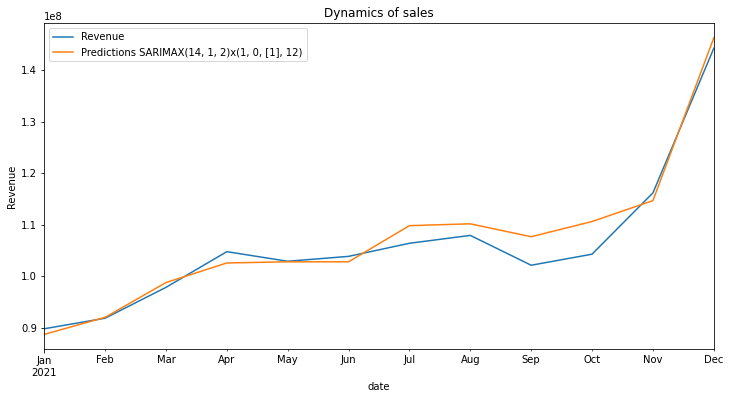

In [146]:
# Построим график прогнозируемых и известных значений
ax1 = test1['Revenue'].plot(legend=True, figsize=(12,6), title = 'Dynamics of sales')
predictions1.plot(legend=True)
ax1.autoscale(axis='x', tight=True)
ax1.set(xlabel='date', ylabel='Revenue')

In [139]:
# Оценим качество модели с помощью MSE и RMSE
error=mean_squared_error(test1['Revenue'], predictions1)
print(f'SARIMA(14, 1, 2)x(1, 0, [1], 12)MSE Error: {error:11.10}')

SARIMA(14, 1, 2)x(1, 0, [1], 12)MSE Error: 8.494957272e+12


In [134]:
error=rmse(test1['Revenue'], predictions1)
print(f'SARIMA(14, 1, 2)x(1, 0, [1], 12)RMSE Error: {error:11.10}')

SARIMA(14, 1, 2)x(1, 0, [1], 12)RMSE Error: 2914610.998


        Модель SARIMA имеет меньшее значение RMSE, чем модель ARIMA, 2 914 610.998 < 52 842 855.82 но все же среднеквадратическая ошибка остается высокой.
       Найдем значение ошибки в прогнозах MAPE.

In [136]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression().fit(X_train , Y_train)
LR_Test_predict = linear_model.predict(X_test) 
LR_MAPE= MAPE(Y_test,LR_Test_predict)
print("MAPE: ",LR_MAPE)

MAPE:  4.111956186018914


In [147]:
# Натренируем модель на полном датасете и предскажем на год вперед.
model = SARIMAX(df['Revenue'], order=(14,1,2), seasonal_order=(0,1,0,12))
results = model.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04871D+01    |proj g|=  3.62185D+00

At iterate    5    f=  1.02669D+01    |proj g|=  3.11582D-02

At iterate   10    f=  1.02661D+01    |proj g|=  1.31173D-01


 This problem is unconstrained.



At iterate   15    f=  1.02443D+01    |proj g|=  9.20046D-01

At iterate   20    f=  1.02105D+01    |proj g|=  1.46484D+00

At iterate   25    f=  1.01983D+01    |proj g|=  6.21119D-01

At iterate   30    f=  1.01871D+01    |proj g|=  2.98756D+00

At iterate   35    f=  1.01743D+01    |proj g|=  4.67843D-01

At iterate   40    f=  1.01634D+01    |proj g|=  2.93574D-01

At iterate   45    f=  1.01598D+01    |proj g|=  1.95069D-01

At iterate   50    f=  1.01587D+01    |proj g|=  1.38694D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   20     50     60      1     0     0   1.387D-01   1.016D+01
  F =   10.1587466664

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Revenue   No. Observations:                   36
Model:             SARIMAX(6, 1, 13)x(0, 1, [], 12)   Log Likelihood                -365.715
Date:                              Sat, 26 Mar 2022   AIC                            771.430
Time:                                      17:40:29   BIC                            794.140
Sample:                                  01-01-2019   HQIC                           777.141
                                       - 12-01-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3931      5.285     -0.074      0.941     -10.751       9.965
ar.L2          0.4062      5.359      0.076      0.940     -10.097      10.909
ar.L3          0.4899      4.564      0.107      0.915      -8.454       9.434
ar.L4          0.4403      7.384      0.060      0.952     -14.032      14.913
ar.L5         -0.5598      8.941     -0.063      0.950     -18.084      16.964
ar.L6         -0.8190      6.327     -0.129      0.897     -13.219      11.581
ma.L1          0.4005      5.038      0.080      0.937      -9.473      10.274
ma.L2         -0.4000      5.348     -0.075      0.940     -10.882      10.082
ma.L3         -0.4893      4.251     -0.115      0.908      -8.821       7.842
ma.L4         -0.4755      6.902     -0.069      0.945     -14.003      13.052
ma.L5          0.5308      8.766      0.061      0.952     -16.651      17.713
ma.L6          0.7823      5.748      0.136      0.892     -10.484      12.049
ma.L7         -0.0054      1.455     -0.004      0.997      -2.857       2.846
ma.L8          0.0189      1.388      0.014      0.989      -2.702       2.740
ma.L9          0.0324      1.195      0.027      0.978      -2.310       2.375
ma.L10         0.0167      0.630      0.026      0.979      -1.219       1.252
ma.L11        -0.0386      2.367     -0.016      0.987      -4.677       4.600
ma.L12        -0.0506      2.123     -0.024      0.981      -4.211       4.110
ma.L13        -0.0250      1.043     -0.024      0.981      -2.068       2.018
sigma2       6.02e+12   2.63e-11   2.29e+23      0.000    6.02e+12    6.02e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                25.76
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):              24.13   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.12e+40. Standard errors may be unstable.
"""

In [148]:
fcast = results.predict(len(df),len(df)+12, type='levels').rename('SARIMA(14, 1, 2)x(0, 1, 0, 12)Forecast')
fcast

2022-01-01    9.136826e+07
2022-02-01    9.401678e+07
2022-03-01    1.021111e+08
2022-04-01    1.064678e+08
2022-05-01    1.048051e+08
2022-06-01    1.079713e+08
2022-07-01    1.105298e+08
2022-08-01    1.105865e+08
2022-09-01    1.063484e+08
2022-10-01    1.100249e+08
2022-11-01    1.196352e+08
2022-12-01    1.475014e+08
2023-01-01    9.604554e+07
Freq: MS, Name: SARIMA(14, 1, 2)x(0, 1, 0, 12)Forecast, dtype: float64

<AxesSubplot:>

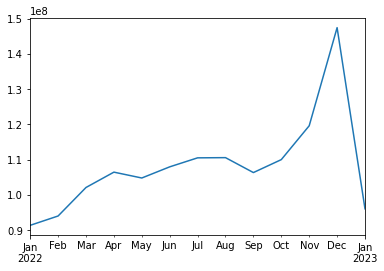

In [149]:
fcast.plot()

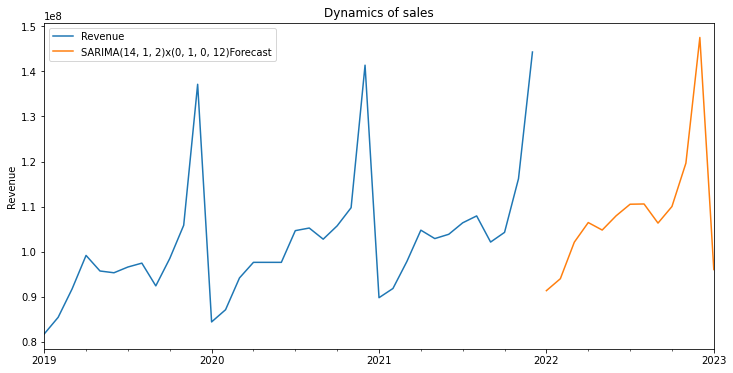

In [150]:
f=df['Revenue'].plot(figsize=(12,6), legend=True, title='Dynamics of sales', xlabel='', ylabel='Revenue')
fcast.plot(legend=True)
l.autoscale(axis='x', tight=True)

        Как можно заметить из графика модель SARIMA строит более точный прогноз. Отчасти это связано с выбросами в исходных данных, которые были заменены на средние значения, а также с возможной недостаточностью данных.